<a href="https://colab.research.google.com/github/marcoppasini/MelGAN-VC/blob/master/MelGAN_VC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://arxiv.org/pdf/1910.03713.pdf

In [1]:
!pip install tensorflow
!pip install soundfile                    #to save wav files
!pip install --no-deps torchaudio
!pip install matplotlib
!pip install image
!pip install scikit-image
!pip install librosa
!pip install torch==1.3.0
!pip install tqdm
!pip install pydub

In [2]:
#We'll be using TF 2.1 and torchaudio

try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf


In [3]:
#Imports

from __future__ import print_function, division
from glob import glob
import scipy
import soundfile as sf
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Concatenate, Conv2D, Conv2DTranspose, GlobalAveragePooling2D, UpSampling2D, LeakyReLU, ReLU, Add, Multiply, Lambda, Dot, BatchNormalization, Activation, ZeroPadding2D, Cropping2D, Cropping1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import TruncatedNormal, he_normal
import tensorflow.keras.backend as K
import datetime
import numpy as np
import random
import matplotlib.pyplot as plt
import collections
from PIL import Image
from skimage.transform import resize
import imageio
import librosa
import librosa.display
from librosa.feature import melspectrogram
import os
import time
import IPython
import multiprocessing

In [4]:
#Hyperparameters

hop=192               #hop size (window size = 6*hop)
sr=16000              #sampling rate
min_level_db=-100     #reference values to normalize data
ref_level_db=20

shape=24              #length of time axis of split specrograms to feed to generator            
vec_len=128           #length of vector generated by siamese vector
# bs = 16               #batch size
bs = 32               #batch size
delta = 2.            #constant for siamese loss


n_fft = 6 * hop
win_length = 6 * hop
max_spec_length = 10 * shape 

In [5]:
import torch
torch.cuda.default_stream(device=0)

<torch.cuda.Stream device=cuda:0 cuda_stream=0x0>

In [6]:
print(torch.cuda.current_device())

0


In [7]:
#There seems to be a problem with Tensorflow STFT, so we'll be using pytorch to handle offline mel-spectrogram generation and waveform reconstruction
#For waveform reconstruction, a gradient-based method is used:

''' Decorsière, Rémi, Peter L. Søndergaard, Ewen N. MacDonald, and Torsten Dau. 
"Inversion of auditory spectrograms, traditional spectrograms, and other envelope representations." 
IEEE/ACM Transactions on Audio, Speech, and Language Processing 23, no. 1 (2014): 46-56.'''

#ORIGINAL CODE FROM https://github.com/yoyololicon/spectrogram-inversion

import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from functools import partial
import math
import heapq
from torchaudio.transforms import MelScale, Spectrogram

torch.set_default_tensor_type('torch.cuda.FloatTensor')
# torch.set_default_tensor_type('torch.FloatTensor')

specobj = Spectrogram(n_fft=6*hop, win_length=6*hop, hop_length=hop, pad=0, power=2, normalized=True)
specfunc = specobj.forward
melobj = MelScale(n_mels=hop, sample_rate=sr, f_min=0.)
melfunc = melobj.forward

def melspecfunc(waveform):
    specgram = specfunc(waveform)
    mel_specgram = melfunc(specgram)
    return mel_specgram

# def melspecfunc(waveform):
#     return librosa.feature.melspectrogram(y=waveform, 
#                                           sr=sr, 
#                                           n_fft=n_fft, 
#                                           win_length=win_length,
#                                           hop_length=hop)

def spectral_convergence(input, target):
    return 20 * ((input - target).norm().log10() - target.norm().log10())

def GRAD(spec, transform_fn, samples=None, init_x0=None, maxiter=1000, tol=1e-6, verbose=1, evaiter=10, lr=0.003):

    spec = torch.Tensor(spec)
    samples = (spec.shape[-1]*hop)-hop

    if init_x0 is None:
        init_x0 = spec.new_empty((1,samples)).normal_(std=1e-6)
    x = nn.Parameter(init_x0)
    T = spec

    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam([x], lr=lr)

    bar_dict = {}
    metric_func = spectral_convergence
    bar_dict['spectral_convergence'] = 0
    metric = 'spectral_convergence'

    init_loss = None
    with tqdm(total=maxiter, disable=not verbose) as pbar:
        for i in range(maxiter):
            optimizer.zero_grad()
            V = transform_fn(x)
            loss = criterion(V, T)
            loss.backward()
            optimizer.step()
            lr = lr*0.9999
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr

            if i % evaiter == evaiter - 1:
                with torch.no_grad():
                    V = transform_fn(x)
                    bar_dict[metric] = metric_func(V, spec).item()
                    l2_loss = criterion(V, spec).item()
                    pbar.set_postfix(**bar_dict, loss=l2_loss)
                    pbar.update(evaiter)

    return x.detach().view(-1).cpu()

def normalize(S):
    return np.clip((((S - min_level_db) / -min_level_db)*2.)-1., -1, 1)

def denormalize(S):
    return (((np.clip(S, -1, 1)+1.)/2.) * -min_level_db) + min_level_db

def prep(wv,hop=192):
    S = np.array(torch.squeeze(melspecfunc(torch.Tensor(wv).view(1,-1))).detach().cpu())
    S = librosa.power_to_db(S)-ref_level_db
    return normalize(S)

# def prep(wv, hop=192):
#     S = np.array(melspecfunc(wv))
#     S = librosa.power_to_db(S)- ref_level_db
#     return normalize(S)

def deprep(S):
    S = denormalize(S)+ref_level_db
    S = librosa.db_to_power(S)
    wv = GRAD(np.expand_dims(S,0), melspecfunc, maxiter=2000, evaiter=10, tol=1e-8)
    return np.array(np.squeeze(wv))

In [8]:
#Helper functions

#Generate spectrograms from waveform array
def tospec(data):
    specs=np.empty(data.shape[0], dtype=object)
    for i in range(data.shape[0]):
        x = data[i]
        S=prep(x)
        S = np.array(S, dtype=np.float32)
        specs[i]=np.expand_dims(S, -1)
    print(specs.shape)
    return specs


# def process_spec(wv):
#     S=prep(wv)
#     S = np.array(S, dtype=np.float32)
#     return S
    
# #Generate spectrograms from waveform array
# def tospec(data):
    
#     cpu_count = multiprocessing.cpu_count()
#     pool = multiprocessing.Pool(cpu_count)
#     specs = np.array(pool.map(process_spec, data))
    
#     print(specs.shape)
#     return specs

#Waveform array from path of folder containing wav files
# def audio_array(path):
#     ls = glob(f'{path}/*.wav')
#     adata = []
#     for i in range(len(ls)):
#         x, sr = tf.audio.decode_wav(tf.io.read_file(ls[i]), 1)
#         x = np.array(x, dtype=np.float32)
#         adata.append(x)
#     return np.array(adata)

def process_wav(path):
    x, sr = librosa.load(path ,sr=16000)
    x, _ = librosa.effects.trim(x)
    return np.array(x, dtype=np.float32)

#Waveform array from path of folder containing wav files
def audio_array(path):
    ls = glob(f'{path}/*.wav')
    
    cpu_count = multiprocessing.cpu_count()
    pool = multiprocessing.Pool(cpu_count)
    adata = pool.map(process_wav, ls)
    return np.array(adata)

#Concatenate spectrograms in array along the time axis
def testass(a):
    but=False
    con = np.array([])
    nim = a.shape[0]
    for i in range(nim):
        im = a[i]
        im = np.squeeze(im)
        if not but:
            con=im
            but=True
        else:
            con = np.concatenate((con,im), axis=1)
    return np.squeeze(con)

# NB shape=24 #length of time axis of split specrograms to feed to generator   
#Split spectrograms in chunks with equal size
def splitcut(data, debug=False):
    ls = []
    mini = data[0].shape[1]
    minifinal = 10*shape                                                              #max spectrogram length
    for i in range(data.shape[0]-1):
        if data[i].shape[1]<=mini:
            mini = data[i].shape[1]
    
    if mini >= 3*shape and mini < minifinal:
        minifinal = mini
        
    if debug:
        print(f"Mininum chunk size is {minifinal}")
    
    for i in range(data.shape[0]):
        x = data[i]
        if debug:
            print(f"{i} {x.shape}-> {x.shape[1]} >= {3*shape}?")
            
        if x.shape[1]>=3*shape:
            if debug:
                print(f" Attempt to break the file up into {x.shape[1]//minifinal} chunks of size {minifinal}")
            
            for n in range(x.shape[1]//minifinal):
                ls.append(x[:,n*minifinal:n*minifinal+minifinal,:])
        ls.append(x[:,-minifinal:,:])
    
    return np.array(ls)


In [9]:
#Generating Mel-Spectrogram dataset (Uncomment where needed)
#adata: source spectrograms
#bdata: target spectrograms

#MALE1
# awv = audio_array('/data/wav/india')                               #get waveform array from folder containing wav files
# aspec = tospec(awv)                                                                 #get spectrogram array
# adata = splitcut(aspec)                                                             #split spectrogams to fixed length
#FEMALE1
# bwv = audio_array('/data/wav/us')
# bspec = tospec(bwv)
# bdata = splitcut(bspec)
# #MALE2
# awv = audio_array('../content/cmu_us_rms_arctic/wav')
# aspec = tospec(awv)
# adata = splitcut(aspec)
# #FEMALE2
# bwv = audio_array('../content/cmu_us_slt_arctic/wav')
# bspec = tospec(bwv)
# bdata = splitcut(bspec)

#JAZZ MUSIC
# awv = audio_array('../content/genres/jazz')
# aspec = tospec(awv)
# adata = splitcut(aspec)
#CLASSICAL MUSIC
# bwv = audio_array('../content/genres/classical')
# bspec = tospec(bwv)
# bdata = splitcut(bspec)

In [10]:
def load_wav_generate_spectograms(input_dir):
    awv = audio_array(input_dir)
    aspec = tospec(awv)
    adata = splitcut(aspec)
    np.savez(f'{input_dir}/data.npz', spec=aspec, data=adata)
    return aspec, adata

def load_spectograms(data_file):
    recs = np.load(data_file, allow_pickle=True)
    adata = recs['data']
    aspec = recs['spec']
    return aspec, adata

In [14]:
indian_dir = '/data/wav/v2/indian'
us_dir = '/data/wav/v2/us_small'

In [33]:
aspec, adata = load_wav_generate_spectograms(indian_dir)
bspec, bdata = load_wav_generate_spectograms(us_dir)

(576,)
(577,)


In [34]:
# aspec, adata = load_spectograms(f'{indian_dir}/data.npz')
# bspec, bdata = load_spectograms(f'{us_dir}/data.npz')

In [35]:
#Creating Tensorflow Datasets

@tf.function
def proc(x):
    return tf.image.random_crop(x, size=[hop, 3*shape, 1])

dsa = tf.data.Dataset.from_tensor_slices(adata).repeat(50).map(proc, num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(10000).batch(bs, drop_remainder=True)
dsb = tf.data.Dataset.from_tensor_slices(bdata).repeat(50).map(proc, num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(10000).batch(bs, drop_remainder=True)

In [36]:
#Adding Spectral Normalization to convolutional layers

from tensorflow.python.keras.utils import conv_utils
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import sparse_ops
from tensorflow.python.ops import gen_math_ops
from tensorflow.python.ops import standard_ops
from tensorflow.python.eager import context
from tensorflow.python.framework import tensor_shape

def l2normalize(v, eps=1e-12):
    return v / (tf.norm(v) + eps)


class ConvSN2D(tf.keras.layers.Conv2D):

    def __init__(self, filters, kernel_size, power_iterations=1, **kwargs):
        super(ConvSN2D, self).__init__(filters, kernel_size, **kwargs)
        self.power_iterations = power_iterations


    def build(self, input_shape):
        super(ConvSN2D, self).build(input_shape)

        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1

        self.u = self.add_weight(self.name + '_u',
            shape=tuple([1, self.kernel.shape.as_list()[-1]]), 
            initializer=tf.initializers.RandomNormal(0, 1),
            trainable=False
        )

    def compute_spectral_norm(self, W, new_u, W_shape):
        for _ in range(self.power_iterations):

            new_v = l2normalize(tf.matmul(new_u, tf.transpose(W)))
            new_u = l2normalize(tf.matmul(new_v, W))
            
        sigma = tf.matmul(tf.matmul(new_v, W), tf.transpose(new_u))
        W_bar = W/sigma

        with tf.control_dependencies([self.u.assign(new_u)]):
            W_bar = tf.reshape(W_bar, W_shape)

        return W_bar


    def call(self, inputs):
        W_shape = self.kernel.shape.as_list()
        W_reshaped = tf.reshape(self.kernel, (-1, W_shape[-1]))
        new_kernel = self.compute_spectral_norm(W_reshaped, self.u, W_shape)
        outputs = self._convolution_op(inputs, new_kernel)

        if self.use_bias:
            if self.data_format == 'channels_first':
                    outputs = tf.nn.bias_add(outputs, self.bias, data_format='NCHW')
            else:
                outputs = tf.nn.bias_add(outputs, self.bias, data_format='NHWC')
        if self.activation is not None:
            return self.activation(outputs)

        return outputs

class ConvSN2DTranspose(tf.keras.layers.Conv2DTranspose):

    def __init__(self, filters, kernel_size, power_iterations=1, **kwargs):
        super(ConvSN2DTranspose, self).__init__(filters, kernel_size, **kwargs)
        self.power_iterations = power_iterations


    def build(self, input_shape):
        super(ConvSN2DTranspose, self).build(input_shape)

        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1

        self.u = self.add_weight(self.name + '_u',
            shape=tuple([1, self.kernel.shape.as_list()[-1]]), 
            initializer=tf.initializers.RandomNormal(0, 1),
            trainable=False
        )

    def compute_spectral_norm(self, W, new_u, W_shape):
        for _ in range(self.power_iterations):

            new_v = l2normalize(tf.matmul(new_u, tf.transpose(W)))
            new_u = l2normalize(tf.matmul(new_v, W))
            
        sigma = tf.matmul(tf.matmul(new_v, W), tf.transpose(new_u))
        W_bar = W/sigma

        with tf.control_dependencies([self.u.assign(new_u)]):
            W_bar = tf.reshape(W_bar, W_shape)

        return W_bar

    def call(self, inputs):
        W_shape = self.kernel.shape.as_list()
        W_reshaped = tf.reshape(self.kernel, (-1, W_shape[-1]))
        new_kernel = self.compute_spectral_norm(W_reshaped, self.u, W_shape)

        inputs_shape = array_ops.shape(inputs)
        batch_size = inputs_shape[0]
        if self.data_format == 'channels_first':
            h_axis, w_axis = 2, 3
        else:
            h_axis, w_axis = 1, 2

        height, width = inputs_shape[h_axis], inputs_shape[w_axis]
        kernel_h, kernel_w = self.kernel_size
        stride_h, stride_w = self.strides

        if self.output_padding is None:
            out_pad_h = out_pad_w = None
        else:
            out_pad_h, out_pad_w = self.output_padding

        out_height = conv_utils.deconv_output_length(height,
                                                    kernel_h,
                                                    padding=self.padding,
                                                    output_padding=out_pad_h,
                                                    stride=stride_h,
                                                    dilation=self.dilation_rate[0])
        out_width = conv_utils.deconv_output_length(width,
                                                    kernel_w,
                                                    padding=self.padding,
                                                    output_padding=out_pad_w,
                                                    stride=stride_w,
                                                    dilation=self.dilation_rate[1])
        if self.data_format == 'channels_first':
            output_shape = (batch_size, self.filters, out_height, out_width)
        else:
            output_shape = (batch_size, out_height, out_width, self.filters)

        output_shape_tensor = array_ops.stack(output_shape)
        outputs = K.conv2d_transpose(
            inputs,
            new_kernel,
            output_shape_tensor,
            strides=self.strides,
            padding=self.padding,
            data_format=self.data_format,
            dilation_rate=self.dilation_rate)

        if not context.executing_eagerly():
            out_shape = self.compute_output_shape(inputs.shape)
            outputs.set_shape(out_shape)

        if self.use_bias:
            outputs = tf.nn.bias_add(
              outputs,
              self.bias,
              data_format=conv_utils.convert_data_format(self.data_format, ndim=4))

        if self.activation is not None:
            return self.activation(outputs)
        return outputs  

class DenseSN(Dense):
    def build(self, input_shape):
        super(DenseSN, self).build(input_shape)

        self.u = self.add_weight(self.name + '_u',
            shape=tuple([1, self.kernel.shape.as_list()[-1]]), 
            initializer=tf.initializers.RandomNormal(0, 1),
            trainable=False)
        
    def compute_spectral_norm(self, W, new_u, W_shape):
        new_v = l2normalize(tf.matmul(new_u, tf.transpose(W)))
        new_u = l2normalize(tf.matmul(new_v, W))
        sigma = tf.matmul(tf.matmul(new_v, W), tf.transpose(new_u))
        W_bar = W/sigma
        with tf.control_dependencies([self.u.assign(new_u)]):
            W_bar = tf.reshape(W_bar, W_shape)
        return W_bar
        
    def call(self, inputs):
        W_shape = self.kernel.shape.as_list()
        W_reshaped = tf.reshape(self.kernel, (-1, W_shape[-1]))
        new_kernel = self.compute_spectral_norm(W_reshaped, self.u, W_shape)
        rank = len(inputs.shape)
        if rank > 2:
            outputs = standard_ops.tensordot(inputs, new_kernel, [[rank - 1], [0]])
            if not context.executing_eagerly():
                shape = inputs.shape.as_list()
                output_shape = shape[:-1] + [self.units]
                outputs.set_shape(output_shape)
        else:
            inputs = math_ops.cast(inputs, self._compute_dtype)
            if K.is_sparse(inputs):
                outputs = sparse_ops.sparse_tensor_dense_matmul(inputs, new_kernel)
            else:
                outputs = gen_math_ops.mat_mul(inputs, new_kernel)
        if self.use_bias:
            outputs = tf.nn.bias_add(outputs, self.bias)
        if self.activation is not None:
            return self.activation(outputs)
        return outputs


In [37]:
#Networks Architecture

init = tf.keras.initializers.he_uniform()

def conv2d(layer_input, filters, kernel_size=4, strides=2, padding='same', leaky=True, bnorm=True, sn=True):
    if leaky:
        Activ = LeakyReLU(alpha=0.2)
    else:
        Activ = ReLU()
    if sn:
        d = ConvSN2D(filters, kernel_size=kernel_size, strides=strides, padding=padding, kernel_initializer=init, use_bias=False)(layer_input)
    else:
        d = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding=padding, kernel_initializer=init, use_bias=False)(layer_input)
    if bnorm:
        d = BatchNormalization()(d)
    d = Activ(d)
    return d

def deconv2d(layer_input, layer_res, filters, kernel_size=4, conc=True, scalev=False, bnorm=True, up=True, padding='same', strides=2):
    if up:
        u = UpSampling2D((1,2))(layer_input)
        u = ConvSN2D(filters, kernel_size, strides=(1,1), kernel_initializer=init, use_bias=False, padding=padding)(u)
    else:
        u = ConvSN2DTranspose(filters, kernel_size, strides=strides, kernel_initializer=init, use_bias=False, padding=padding)(layer_input)
    if bnorm:
        u = BatchNormalization()(u)
    u = LeakyReLU(alpha=0.2)(u)
    if conc:
        u = Concatenate()([u,layer_res])
    return u

#Extract function: splitting spectrograms
def extract_image(im):
    im1 = Cropping2D(((0,0), (0, 2*(im.shape[2]//3))))(im)
    im2 = Cropping2D(((0,0), (im.shape[2]//3,im.shape[2]//3)))(im)
    im3 = Cropping2D(((0,0), (2*(im.shape[2]//3), 0)))(im)
    return im1,im2,im3

#Assemble function: concatenating spectrograms
def assemble_image(lsim):
    im1,im2,im3 = lsim
    imh = Concatenate(2)([im1,im2,im3])
    return imh

#U-NET style architecture
def build_generator(input_shape):
    h,w,c = input_shape
    inp = Input(shape=input_shape)
    #downscaling
    g0 = tf.keras.layers.ZeroPadding2D((0,1))(inp)
    g1 = conv2d(g0, 256, kernel_size=(h,3), strides=1, padding='valid')
    g2 = conv2d(g1, 256, kernel_size=(1,9), strides=(1,2))
    g3 = conv2d(g2, 256, kernel_size=(1,7), strides=(1,2))
    #upscaling
    g4 = deconv2d(g3,g2, 256, kernel_size=(1,7), strides=(1,2))
    g5 = deconv2d(g4,g1, 256, kernel_size=(1,9), strides=(1,2), bnorm=False)
    g6 = ConvSN2DTranspose(1, kernel_size=(h,1), strides=(1,1), kernel_initializer=init, padding='valid', activation='tanh')(g5)
    return Model(inp,g6, name='G')

#Siamese Network
def build_siamese(input_shape):
    h,w,c = input_shape
    inp = Input(shape=input_shape)
    g1 = conv2d(inp, 256, kernel_size=(h,3), strides=1, padding='valid', sn=False)
    g2 = conv2d(g1, 256, kernel_size=(1,9), strides=(1,2), sn=False)
    g3 = conv2d(g2, 256, kernel_size=(1,7), strides=(1,2), sn=False)
    g4 = Flatten()(g3)
    g5 = Dense(vec_len)(g4)
    return Model(inp, g5, name='S')

#Discriminator (Critic) Network
def build_critic(input_shape):
    h,w,c = input_shape
    inp = Input(shape=input_shape)
    g1 = conv2d(inp, 512, kernel_size=(h,3), strides=1, padding='valid', bnorm=False)
    g2 = conv2d(g1, 512, kernel_size=(1,9), strides=(1,2), bnorm=False)
    g3 = conv2d(g2, 512, kernel_size=(1,7), strides=(1,2), bnorm=False)
    g4 = Flatten()(g3)
    g4 = DenseSN(1, kernel_initializer=init)(g4)
    return Model(inp, g4, name='C')

In [38]:
#Load past models from path to resume training or test
def load(path):
    gen = build_generator((hop,shape,1))
    siam = build_siamese((hop,shape,1))
    critic = build_critic((hop,3*shape,1))
    gen.load_weights(path+'/gen.h5')
    critic.load_weights(path+'/critic.h5')
    siam.load_weights(path+'/siam.h5')
    return gen,critic,siam

#Build models
def build():
    gen = build_generator((hop,shape,1))
    siam = build_siamese((hop,shape,1))
    critic = build_critic((hop,3*shape,1))                                          #the discriminator accepts as input spectrograms of triple the width of those generated by the generator
    return gen,critic,siam

#Generate a random batch to display current training results
def testgena():
    sw = True
    while sw:
        a = np.random.choice(aspec)
        if a.shape[1]//shape!=1:
            sw=False
    dsa = []
    if a.shape[1]//shape>6:
        num=6
    else:
        num=a.shape[1]//shape
    rn = np.random.randint(a.shape[1]-(num*shape))
    for i in range(num):
        im = a[:,rn+(i*shape):rn+(i*shape)+shape]
        im = np.reshape(im, (im.shape[0],im.shape[1],1))
        dsa.append(im)
    return np.array(dsa, dtype=np.float32)

#Show results mid-training
def save_test_image_full(path):
    a = testgena()
    print(a.shape)
    ab = gen(a, training=False)
    ab = testass(ab)
    a = testass(a)
    abwv = deprep(ab)
    awv = deprep(a)
    sf.write(path+'/new_file.wav', abwv, sr)
    IPython.display.display(IPython.display.Audio(np.squeeze(abwv), rate=sr))
    IPython.display.display(IPython.display.Audio(np.squeeze(awv), rate=sr))
    fig, axs = plt.subplots(ncols=2)
    axs[0].imshow(np.flip(a, -2), cmap=None)
    axs[0].axis('off')
    axs[0].set_title('Source')
    axs[1].imshow(np.flip(ab, -2), cmap=None)
    axs[1].axis('off')
    axs[1].set_title('Generated')
    plt.show()

#Save in training loop
def save_end(epoch,gloss,closs,mloss,n_save=3,save_path='/data/output/models'):                 #use custom save_path (i.e. Drive '../content/drive/My Drive/')
    if epoch % n_save == 0:
        print('Saving...')
        path = f'{save_path}/MELGANVC-{str(gloss)[:9]}-{str(closs)[:9]}-{str(mloss)[:9]}'
        os.mkdir(path)
        gen.save_weights(path+'/gen.h5')
        critic.save_weights(path+'/critic.h5')
        siam.save_weights(path+'/siam.h5')
        save_test_image_full(path)

In [39]:
#Losses

def mae(x,y):
    return tf.reduce_mean(tf.abs(x-y))

def mse(x,y):
    return tf.reduce_mean((x-y)**2)

def loss_travel(sa,sab,sa1,sab1):
    l1 = tf.reduce_mean(((sa-sa1) - (sab-sab1))**2)
    l2 = tf.reduce_mean(tf.reduce_sum(-(tf.nn.l2_normalize(sa-sa1, axis=[-1]) * tf.nn.l2_normalize(sab-sab1, axis=[-1])), axis=-1))
    return l1+l2

def loss_siamese(sa,sa1):
    logits = tf.sqrt(tf.reduce_sum((sa-sa1)**2, axis=-1, keepdims=True))
    return tf.reduce_mean(tf.square(tf.maximum((delta - logits), 0)))

def d_loss_f(fake):
    return tf.reduce_mean(tf.maximum(1 + fake, 0))

def d_loss_r(real):
    return tf.reduce_mean(tf.maximum(1 - real, 0))

def g_loss_f(fake):
    return tf.reduce_mean(- fake)

In [40]:
#Get models and optimizers
def get_networks(shape, load_model=False, path=None):
    if not load_model:
        gen,critic,siam = build()
    else:
        gen,critic,siam = load(path)

    opt_gen = Adam(0.0001, 0.5)
    opt_disc = Adam(0.0001, 0.5)

    return gen,critic,siam, [opt_gen,opt_disc]

#Set learning rate
def update_lr(lr):
    opt_gen.learning_rate = lr
    opt_disc.learning_rate = lr

In [41]:
#Training Functions

#Train Generator, Siamese and Critic
@tf.function
def train_all(a,b):
    #splitting spectrogram in 3 parts
    aa,aa2,aa3 = extract_image(a) 
    bb,bb2,bb3 = extract_image(b)

    with tf.GradientTape() as tape_gen, tf.GradientTape() as tape_disc:
        #translating A to B
        fab = gen(aa, training=True)
        fab2 = gen(aa2, training=True)
        fab3 = gen(aa3, training=True)
        #identity mapping B to B                                                        COMMENT THESE 3 LINES IF THE IDENTITY LOSS TERM IS NOT NEEDED
        fid = gen(bb, training=True) 
        fid2 = gen(bb2, training=True)
        fid3 = gen(bb3, training=True)
        #concatenate/assemble converted spectrograms
        fabtot = assemble_image([fab,fab2,fab3])
        #feed concatenated spectrograms to critic
        cab = critic(fabtot, training=True)
        cb = critic(b, training=True)
        #feed 2 pairs (A,G(A)) extracted spectrograms to Siamese
        sab = siam(fab, training=True)
        sab2 = siam(fab3, training=True)
        sa = siam(aa, training=True)
        sa2 = siam(aa3, training=True)
        #identity mapping loss
        loss_id = (mae(bb,fid)+mae(bb2,fid2)+mae(bb3,fid3))/3.                         #loss_id = 0. IF THE IDENTITY LOSS TERM IS NOT NEEDED
        #travel loss
        loss_m = loss_travel(sa,sab,sa2,sab2)+loss_siamese(sa,sa2)
        #generator and critic losses
        loss_g = g_loss_f(cab)
        loss_dr = d_loss_r(cb)
        loss_df = d_loss_f(cab)
        loss_d = (loss_dr+loss_df)/2.
        #generator+siamese total loss
        lossgtot = loss_g+10.*loss_m+0.5*loss_id                                       #CHANGE LOSS WEIGHTS HERE  (COMMENT OUT +w*loss_id IF THE IDENTITY LOSS TERM IS NOT NEEDED)
  
    #computing and applying gradients
    grad_gen = tape_gen.gradient(lossgtot, gen.trainable_variables+siam.trainable_variables)
    opt_gen.apply_gradients(zip(grad_gen, gen.trainable_variables+siam.trainable_variables))

    grad_disc = tape_disc.gradient(loss_d, critic.trainable_variables)
    opt_disc.apply_gradients(zip(grad_disc, critic.trainable_variables))

    return loss_dr,loss_df,loss_g,loss_id

#Train Critic only
@tf.function
def train_d(a,b):
    aa,aa2,aa3 = extract_image(a)
    with tf.GradientTape() as tape_disc:

        fab = gen(aa, training=True)
        fab2 = gen(aa2, training=True)
        fab3 = gen(aa3, training=True)
        fabtot = assemble_image([fab,fab2,fab3])

        cab = critic(fabtot, training=True)
        cb = critic(b, training=True)

        loss_dr = d_loss_r(cb)
        loss_df = d_loss_f(cab)

        loss_d = (loss_dr+loss_df)/2.
  
    grad_disc = tape_disc.gradient(loss_d, critic.trainable_variables)
    opt_disc.apply_gradients(zip(grad_disc, critic.trainable_variables))

    return loss_dr,loss_df

In [42]:
#Training Loop

def train(epochs, batch_size=16, lr=0.0001, n_save=6, gupt=5, dsa =[], dsb=[], save_path=''):
    update_lr(lr)
    df_list = []
    dr_list = []
    g_list = []
    id_list = []
    c = 0
    g = 0

    for epoch in range(epochs):
        bef = time.time()
        
        for batchi,(a,b) in enumerate(zip(dsa,dsb)):
          
            if batchi % gupt==0:
                dloss_t,dloss_f,gloss,idloss = train_all(a,b)
            else:
                dloss_t,dloss_f = train_d(a,b)

            df_list.append(dloss_f)
            dr_list.append(dloss_t)
            g_list.append(gloss)
            id_list.append(idloss)
            c += 1
            g += 1

            if batchi%600==0:
                print(f'[Epoch {epoch}/{epochs}] [Batch {batchi}] [D loss f: {np.mean(df_list[-g:], axis=0)} ', end='')
                print(f'r: {np.mean(dr_list[-g:], axis=0)}] ', end='')
                print(f'[G loss: {np.mean(g_list[-g:], axis=0)}] ', end='')
                print(f'[ID loss: {np.mean(id_list[-g:])}] ', end='')
                print(f'[LR: {lr}]')
                g = 0
            nbatch=batchi

        print(f'Completed epoch {epoch}/{epochs} /t Time/Batch {(time.time()-bef)/nbatch}')
        save_end(epoch,np.mean(g_list[-n_save*c:], axis=0),np.mean(df_list[-n_save*c:], axis=0),np.mean(id_list[-n_save*c:], axis=0),n_save=n_save, save_path=save_path)
        print(f'Mean D loss: {np.mean(df_list[-c:], axis=0)} Mean G loss: {np.mean(g_list[-c:], axis=0)} Mean ID loss: {np.mean(id_list[-c:], axis=0)}')
        c = 0
     

In [43]:
expr_dir="/data/output/models/exp_LR_01"
os.makedirs(expr_dir, exist_ok = True)

In [44]:
#Build models and initialize optimizers

#If load_model=True, specify the path where the models are saved

gen,critic,siam, [opt_gen,opt_disc] = get_networks(shape, load_model=False, path=expr_dir)

[Epoch 0/11] [Batch 0] [D loss f: 0.9827927350997925 r: 1.0689351558685303] [G loss: 0.017207246273756027] [ID loss: 0.6060793995857239] [LR: 0.01]
[Epoch 0/11] [Batch 600] [D loss f: 0.616877019405365 r: 0.5210592150688171] [G loss: 0.9899969696998596] [ID loss: 0.20542119443416595] [LR: 0.01]
[Epoch 0/11] [Batch 1200] [D loss f: 0.4182616174221039 r: 0.5609794855117798] [G loss: 1.1548248529434204] [ID loss: 0.17660151422023773] [LR: 0.01]
[Epoch 0/11] [Batch 1800] [D loss f: 0.03487745672464371 r: 0.04542067274451256] [G loss: 1.9319268465042114] [ID loss: 0.1941348761320114] [LR: 0.01]
[Epoch 0/11] [Batch 2400] [D loss f: 0.029426168650388718 r: 0.0454828105866909] [G loss: 1.8765290975570679] [ID loss: 0.16653002798557281] [LR: 0.01]
Completed epoch 0/11 /t Time/Batch 0.0336691371196815


  0%|          | 0/2000 [00:00<?, ?it/s, loss=0.000665, spectral_convergence=-.212]

Saving...
(6, 192, 24, 1)


100%|██████████| 2000/2000 [00:03<00:00, 528.77it/s, loss=2.47e-5, spectral_convergence=-43.5]


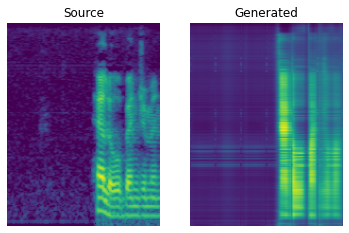

Mean D loss: 0.2536841332912445 Mean G loss: 1.502598524093628 Mean ID loss: 0.1824316829442978
[Epoch 1/11] [Batch 0] [D loss f: 0.10221575200557709 r: 0.1829644739627838] [G loss: 1.607834815979004] [ID loss: 0.15835139155387878] [LR: 0.01]
[Epoch 1/11] [Batch 600] [D loss f: 0.12115199863910675 r: 0.19469255208969116] [G loss: 1.6171754598617554] [ID loss: 0.15328295528888702] [LR: 0.01]
[Epoch 1/11] [Batch 1200] [D loss f: 0.1418871432542801 r: 0.19565154612064362] [G loss: 1.5297558307647705] [ID loss: 0.1518644243478775] [LR: 0.01]
[Epoch 1/11] [Batch 1800] [D loss f: 0.1438983529806137 r: 0.19955375790596008] [G loss: 1.536532998085022] [ID loss: 0.1477462500333786] [LR: 0.01]
[Epoch 1/11] [Batch 2400] [D loss f: 0.16330194473266602 r: 0.21497686207294464] [G loss: 1.6363946199417114] [ID loss: 0.14936421811580658] [LR: 0.01]
Completed epoch 1/11 /t Time/Batch 0.027300442713362072
Mean D loss: 0.14517591893672943 Mean G loss: 1.5879422426223755 Mean ID loss: 0.15053103864192963


  1%|          | 20/2000 [00:00<00:05, 339.38it/s, loss=0.00516, spectral_convergence=-1.11]

Saving...
(6, 192, 24, 1)


100%|██████████| 2000/2000 [00:03<00:00, 515.81it/s, loss=2.88e-5, spectral_convergence=-40.7]


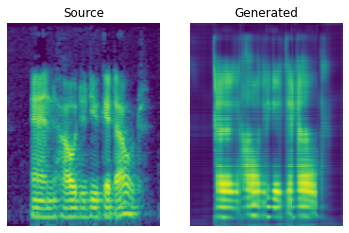

Mean D loss: 0.20082354545593262 Mean G loss: 1.5886844396591187 Mean ID loss: 0.14807985723018646
[Epoch 3/11] [Batch 0] [D loss f: 0.23125247657299042 r: 0.263370543718338] [G loss: 1.5280479192733765] [ID loss: 0.1466815173625946] [LR: 0.01]
[Epoch 3/11] [Batch 600] [D loss f: 0.22157765924930573 r: 0.2590148448944092] [G loss: 1.5586662292480469] [ID loss: 0.14709004759788513] [LR: 0.01]
[Epoch 3/11] [Batch 1200] [D loss f: 0.23373016715049744 r: 0.26958125829696655] [G loss: 1.497664213180542] [ID loss: 0.14748285710811615] [LR: 0.01]
[Epoch 3/11] [Batch 1800] [D loss f: 0.24700391292572021 r: 0.26994383335113525] [G loss: 1.485625982284546] [ID loss: 0.14836177229881287] [LR: 0.01]
[Epoch 3/11] [Batch 2400] [D loss f: 0.24328261613845825 r: 0.28221815824508667] [G loss: 1.336934208869934] [ID loss: 0.14740914106369019] [LR: 0.01]
Completed epoch 3/11 /t Time/Batch 0.02731501286328165
Mean D loss: 0.24014714360237122 Mean G loss: 1.4441593885421753 Mean ID loss: 0.1476140320301056

  1%|          | 20/2000 [00:00<00:06, 310.10it/s, loss=0.00204, spectral_convergence=-1.14]

Saving...
(6, 192, 24, 1)


100%|██████████| 2000/2000 [00:03<00:00, 520.73it/s, loss=7.69e-6, spectral_convergence=-36.4]


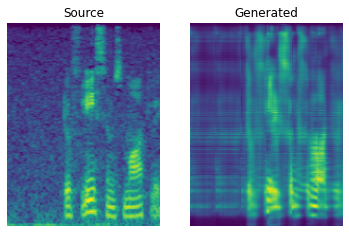

Mean D loss: 0.29535460472106934 Mean G loss: 1.270595908164978 Mean ID loss: 0.1479509323835373
[Epoch 5/11] [Batch 0] [D loss f: 0.3094633221626282 r: 0.34242329001426697] [G loss: 1.2052992582321167] [ID loss: 0.14423802495002747] [LR: 0.01]
[Epoch 5/11] [Batch 600] [D loss f: 0.3388158082962036 r: 0.3530658185482025] [G loss: 1.2371187210083008] [ID loss: 0.14517545700073242] [LR: 0.01]
[Epoch 5/11] [Batch 1200] [D loss f: 0.3437480926513672 r: 0.3510498106479645] [G loss: 1.1470102071762085] [ID loss: 0.14600807428359985] [LR: 0.01]
[Epoch 5/11] [Batch 1800] [D loss f: 0.3385409414768219 r: 0.3563425838947296] [G loss: 1.189517617225647] [ID loss: 0.14480267465114594] [LR: 0.01]
[Epoch 5/11] [Batch 2400] [D loss f: 0.3584541976451874 r: 0.36958640813827515] [G loss: 1.1280597448349] [ID loss: 0.14512111246585846] [LR: 0.01]
Completed epoch 5/11 /t Time/Batch 0.027235848326963127
Mean D loss: 0.3475415110588074 Mean G loss: 1.1681808233261108 Mean ID loss: 0.1449127346277237
[Epoch

  2%|▏         | 30/2000 [00:00<00:05, 388.67it/s, loss=0.00162, spectral_convergence=-4.15]

Saving...
(6, 192, 24, 1)


100%|██████████| 2000/2000 [00:03<00:00, 540.62it/s, loss=9.2e-6, spectral_convergence=-30.1] 


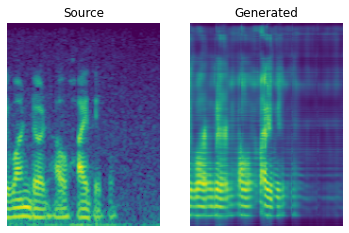

Mean D loss: 0.37773582339286804 Mean G loss: 1.0719841718673706 Mean ID loss: 0.14262299239635468
[Epoch 7/11] [Batch 0] [D loss f: 0.37961894273757935 r: 0.39683255553245544] [G loss: 0.9841057062149048] [ID loss: 0.1422092467546463] [LR: 0.01]
[Epoch 7/11] [Batch 600] [D loss f: 0.3916030824184418 r: 0.395719975233078] [G loss: 1.052067518234253] [ID loss: 0.14118452370166779] [LR: 0.01]
[Epoch 7/11] [Batch 1200] [D loss f: 0.40489304065704346 r: 0.4059043824672699] [G loss: 1.0919151306152344] [ID loss: 0.14061634242534637] [LR: 0.01]
[Epoch 7/11] [Batch 1800] [D loss f: 0.4039958119392395 r: 0.4094177782535553] [G loss: 1.0653471946716309] [ID loss: 0.14162427186965942] [LR: 0.01]
[Epoch 7/11] [Batch 2400] [D loss f: 0.39938318729400635 r: 0.42044803500175476] [G loss: 0.9910902976989746] [ID loss: 0.14017534255981445] [LR: 0.01]
Completed epoch 7/11 /t Time/Batch 0.027167088530525504
Mean D loss: 0.40093275904655457 Mean G loss: 1.0472460985183716 Mean ID loss: 0.1408309042453766

  1%|          | 20/2000 [00:00<00:06, 328.86it/s, loss=0.00435, spectral_convergence=-.566]

Saving...
(6, 192, 24, 1)


100%|██████████| 2000/2000 [00:03<00:00, 539.16it/s, loss=3.21e-5, spectral_convergence=-48]  


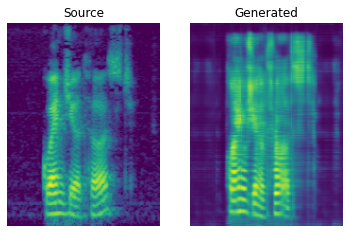

Mean D loss: 0.41971665620803833 Mean G loss: 0.9782237410545349 Mean ID loss: 0.1395903378725052
[Epoch 9/11] [Batch 0] [D loss f: 0.42576098442077637 r: 0.4240185022354126] [G loss: 0.9597218632698059] [ID loss: 0.1386607587337494] [LR: 0.01]
[Epoch 9/11] [Batch 600] [D loss f: 0.4210708439350128 r: 0.42250779271125793] [G loss: 1.0059714317321777] [ID loss: 0.13939189910888672] [LR: 0.01]
[Epoch 9/11] [Batch 1200] [D loss f: 0.43367981910705566 r: 0.43017807602882385] [G loss: 1.009949803352356] [ID loss: 0.1396557092666626] [LR: 0.01]
[Epoch 9/11] [Batch 1800] [D loss f: 0.42876866459846497 r: 0.434732049703598] [G loss: 0.9464979767799377] [ID loss: 0.14064949750900269] [LR: 0.01]
[Epoch 9/11] [Batch 2400] [D loss f: 0.4256022274494171 r: 0.43542084097862244] [G loss: 0.9233758449554443] [ID loss: 0.1397809386253357] [LR: 0.01]
Completed epoch 9/11 /t Time/Batch 0.02710082121288546
Mean D loss: 0.4274456202983856 Mean G loss: 0.9754234552383423 Mean ID loss: 0.13980448246002197
[E

  2%|▏         | 30/2000 [00:00<00:04, 407.68it/s, loss=0.0132, spectral_convergence=-.795] 

Saving...
(6, 192, 24, 1)


100%|██████████| 2000/2000 [00:03<00:00, 546.46it/s, loss=1.06e-5, spectral_convergence=-36.6]


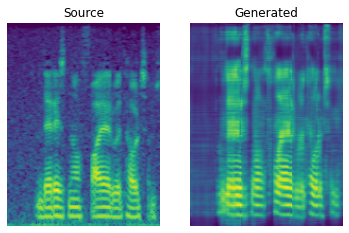

Mean D loss: 0.3997715413570404 Mean G loss: 0.9960169792175293 Mean ID loss: 0.13984723389148712


In [45]:
#Training

#n_save = how many epochs between each saving and displaying of results
#gupt = how many discriminator updates for generator+siamese update

train(11, batch_size=bs, lr=0.01, n_save=2, gupt=3, dsa=dsa, dsb=dsb, save_path=expr_dir)

In [ ]:
#After Training, use these functions to convert data with the generator and save the results

#Assembling generated Spectrogram chunks into final Spectrogram
def specass(a,spec):
  but=False
  con = np.array([])
  nim = a.shape[0]
  for i in range(nim-1):
    im = a[i]
    im = np.squeeze(im)
    if not but:
      con=im
      but=True
    else:
      con = np.concatenate((con,im), axis=1)
  diff = spec.shape[1]-(nim*shape)
  a = np.squeeze(a)
  con = np.concatenate((con,a[-1,:,-diff:]), axis=1)
  return np.squeeze(con)

#Splitting input spectrogram into different chunks to feed to the generator
def chopspec(spec):
  dsa=[]
  for i in range(spec.shape[1]//shape):
    im = spec[:,i*shape:i*shape+shape]
    im = np.reshape(im, (im.shape[0],im.shape[1],1))
    dsa.append(im)
  imlast = spec[:,-shape:]
  imlast = np.reshape(imlast, (imlast.shape[0],imlast.shape[1],1))
  dsa.append(imlast)
  return np.array(dsa, dtype=np.float32)

#Converting from source Spectrogram to target Spectrogram
def towave(spec, name, path='../content/', show=False):
  specarr = chopspec(spec)
  print(specarr.shape)
  a = specarr
  print('Generating...')
  ab = gen(a, training=False)
  print('Assembling and Converting...')
  a = specass(a,spec)
  ab = specass(ab,spec)
  awv = deprep(a)
  abwv = deprep(ab)
  print('Saving...')
  pathfin = f'{path}/{name}'
  os.mkdir(pathfin)
  sf.write(pathfin+'/AB.wav', abwv, sr)
  sf.write(pathfin+'/A.wav', awv, sr)
  print('Saved WAV!')
  IPython.display.display(IPython.display.Audio(np.squeeze(abwv), rate=sr))
  IPython.display.display(IPython.display.Audio(np.squeeze(awv), rate=sr))
  if show:
    fig, axs = plt.subplots(ncols=2)
    axs[0].imshow(np.flip(a, -2), cmap=None)
    axs[0].axis('off')
    axs[0].set_title('Source')
    axs[1].imshow(np.flip(ab, -2), cmap=None)
    axs[1].axis('off')
    axs[1].set_title('Generated')
    plt.show()
  return abwv

In [ ]:
# running inference

gen,critic,siam, [opt_gen,opt_disc] = get_networks(shape, load_model=True, path='/data/output/models/exp4/MELGANVC-0.4230792-0.6292385-0.0805247')

wv, sr = librosa.load('/data/wav/v1/india/common_voice_en_18882406.wav', sr=16000)  #Load waveform
print(wv.shape)
speca = prep(wv)                                                    #Waveform to Spectrogram

plt.figure(figsize=(50,1))                                          #Show Spectrogram
plt.imshow(np.flip(speca, axis=0), cmap=None)
plt.axis('off')
plt.show()

abwv = towave(speca, name='test7', path='.')           #Convert and save wav

In [ ]:
#Wav to wav conversion

wv, sr = librosa.load(librosa.util.example_audio_file(), sr=16000)  #Load waveform
print(wv.shape)
speca = prep(wv)                                                    #Waveform to Spectrogram

plt.figure(figsize=(50,1))                                          #Show Spectrogram
plt.imshow(np.flip(speca, axis=0), cmap=None)
plt.axis('off')
plt.show()

abwv = towave(speca, name='FILENAME1', path='./')           #Convert and save wav